# Breaking CAPTCHAs with Deep Learning: A fast.ai Approach

Ever wonder how those distorted text challenges called CAPTCHAs work—and how we might teach computers to solve them? Today we're diving into a practical machine learning project that combines computer vision and sequence recognition to crack this fascinating problem.

## The Big Picture: Why CAPTCHAs Matter

Before we get into the code, let's understand what we're really doing here. CAPTCHA recognition isn't just about bypassing security measures (which you shouldn't do without permission!). It's about solving a fundamental AI challenge: teaching machines to perceive and interpret visual sequences much like humans do.

This project demonstrates a powerful pattern in machine learning: **breaking complex problems into specialized sub-tasks**. Rather than building one massive model to handle everything, we'll use specialized components that excel at different aspects of the problem.

## What will we learn today

- Image processing: Handling and transforming image data.


- Deep learning architectures: Combining Convolutional Neural Networks (CNNs) for feature extraction and Recurrent Neural Networks (RNNs) for sequence processing.

- Specialized loss functions: Like Connectionist Temporal Classification (CTC) loss, which is essential for sequence-to-sequence tasks where alignment is unknown.


This notebook focuses on building such a model for educational purposes, demonstrating a powerful approach to sequence recognition in images.

## The Architecture: CNN + LSTM + CTC

Our solution uses three key elements:

1. **Convolutional Neural Networks (CNNs)** to process the image
2. **Long Short-Term Memory networks (LSTMs)** to interpret the sequence
3. **Connectionist Temporal Classification (CTC)** to handle alignment uncertainty

Let's see how these pieces work together using fast.ai and PyTorch.

## Objective of this notebook

1. Generate a synthetic dataset of CAPTCHA images and their corresponding text labels.
2. Preprocess the data into a format suitable for training a deep learning model using fastai.
3. Define and implement a CRNN model architecture tailored for CAPTCHA recognition.
4. Utilize CTC loss for training the model, which handles variable-length predictions.
5. Train the model using fastai's Learner and best practices like learning rate finding and one-cycle policy.
6. Visualize and evaluate the model's performance.

In [1]:
from fastai.vision.all import *
from fastai.text.all import *
from datasets import Dataset
from captcha.image import ImageCaptcha
import random
import string

In [2]:
from src.utils import *
from src.metrics import *

# Dataset

In [3]:
# 2. Create a fake CAPTCHA dataset
def create_captcha_dataset(size=100):
    generator = ImageCaptcha(width=160, height=60)
    data = []
    for _ in range(size):
        label = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
        img = generator.generate_image(label)
        data.append({'image': img, 'label': label})  # Using our custom class
    return Dataset.from_list(data)


The `create_captcha_dataset` function generates our synthetic CAPTCHA dataset.
It initializes `ImageCaptcha` with a specified width and height for the images.
It then loops `size` times:


A random 5-character label is generated using uppercase letters and digits.
An image is generated for this label.
The image and its label are stored as a dictionary.


Finally, it converts this list of dictionaries into a datasets.Dataset object, which is a convenient format for handling data.

In [4]:

# 3. Generate the dataset
ds = create_captcha_dataset(1000)

<Axes: title={'center': '5YEX8'}>

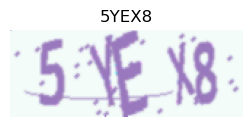

In [5]:
show_image(ds[0]['image'],title=ds[0]['label'],figsize=(3,5))

This line displays the first image from our dataset along with its label, allowing us to visually inspect what our generated CAPTCHAs look like.

## Step 1: Creating Our **DataLoaders**

For dataloaders, we need to create data types. Since, we wanted to use Transformation pipeline which converts tensors from objects and viceversa. It's advisable to create a custom Transform to handle labels

In [6]:
class CaptchaStr(str):
    def show(self, ctx=None, **kwargs):
        return show_title(self, ctx=ctx)

class TokenizeLabel(Transform):
    vocab = list(string.ascii_uppercase + string.digits)
    def __init__(self):
        self.stoi = {v: k for k, v in enumerate(self.vocab)}

    def encodes(self, x: str):
        return TensorText(tensor([self.stoi[c] for c in x]))

    def decodes(self, x: TensorText):
        indices = x.detach().cpu().flatten().tolist()
        return CaptchaStr(''.join(self.vocab[int(i)] for i in indices))


In [65]:
dblock = DataBlock(
    blocks=(ImageBlock, TransformBlock(type_tfms=TokenizeLabel())),
    get_x=lambda o: o['image'],
    get_y=lambda o: o['label'],  # Already a CaptchaLabel instance
    splitter=RandomSplitter(),
    item_tfms=None,
    batch_tfms=[Normalize()]
)

# 7. Create DataLoaders
dls = dblock.dataloaders(ds, bs=64)

- `blocks=(ImageBlock, TransformBlock(type_tfms=TokenizeLabel()))`: This tells fastai that each item in our dataset consists of two parts: an image (handled by ImageBlock) and a label that needs to be processed by our TokenizeLabel transform.
    - `get_x=lambda o: o['image']`: A function to extract the input (image) from a dataset item o.
    - `get_y=lambda o: o['label']`: A function to extract the target (label) from a dataset item o.
    - `splitter=RandomSplitter()`: Specifies that the data should be randomly split into training and validation sets.
    - `item_tfms=None`: We are not applying any item-level transforms here (like resizing individual images) because our images are already generated at the correct size. TokenizeLabel is a type_tfms which acts on the type.
    - `batch_tfms=[Normalize()]`: Batch-level transforms are applied to a whole batch of data at once. Normalize standardizes the pixel values of the images in the batch using ImageNet statistics by default.
    - `dls = dblock.dataloaders(ds, bs=16)`: This line actually creates the DataLoaders from our Hugging Face dataset ds with a batch size of 16.

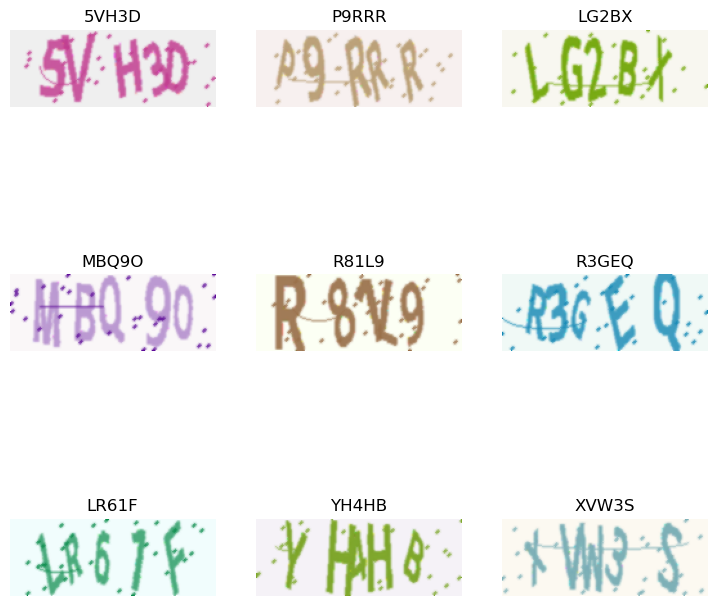

In [66]:
dls.show_batch()

## Step 2: The CNN Backbone - Our Visual Feature Extractor

- `CNNBackbone(nn.Module)`: This class defines the Convolutional Neural Network part of our CRNN.
    - It consists of four convolutional blocks (conv_block1 to conv_block4). Each block typically includes:
        - `nn.Conv2d`: 2D convolution layer to learn spatial features.
        - `nn.BatchNorm2d`: Batch normalization to stabilize and speed up training.
        - `nn.ReLU`: ReLU activation function.
        - `nn.MaxPool2d`: Max pooling to downsample the feature maps and make the model more robust to variations in position.
        - The comments indicate the change in feature map dimensions after each pooling layer.
        - `self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 40))`: This is a key layer. After the convolutional blocks, the feature map has a certain height and width. This adaptive pooling layer resizes the height to 1 while keeping the width at 40 (or forcing it to 40). This transforms the 2D feature map into a sequence of feature vectors, which is the required input format for the subsequent RNN. The output shape will be [batch_size, num_channels, 1, sequence_width].
        - The forward method defines how input x flows through these blocks.

In [67]:
from fastai.vision.all import *
import torch.nn as nn
import torch.nn.functional as F

class CNNBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(3, 64, ks=3, stride=2)   # Output: [bs, 64, 30, 80]
        self.conv2 = ConvLayer(64, 128, ks=3, stride=2) # Output: [bs, 128, 15, 40]
        self.conv3 = nn.Sequential(
            ConvLayer(128, 256, ks=3),
            ConvLayer(256, 256, ks=3),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)) # Output: [bs, 256, 7, 40]
        )
        self.conv4 = nn.Sequential(
            ConvLayer(256, 512, ks=3),
            ConvLayer(512, 512, ks=3),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=(2,1), stride=(2,1)) # Output: [bs, 512, 3, 40]
        )
        self.pool = nn.AdaptiveAvgPool2d((1, None))  # Output: [bs, 512, 1, W]

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool(x) # Output: [bs, 512, 1, 40]
        return x


Notice how we're gradually reducing the height while preserving the width—this transforms the 2D image into a 1D sequence of features, perfect for our LSTM to process.

## Step 3: The CRNN Model - Combining Vision and Sequence Processing

Now we connect the CNN to an LSTM to handle the sequential nature of text:

In [82]:
class CRNN(nn.Module):
    def __init__(self, num_chars):
        super().__init__()
        self.cnn = CNNBackbone()
        # CNN output: [bs, 512, 1, 40]
        lstm_input_size = 512
        hidden_size = 256
        self.num_chars = num_chars

        # Bidirectional LSTM layers
        self.lstm = nn.LSTM(
            lstm_input_size,
            hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=False,
            dropout=0.2
        )

        # Initialize LSTM parameters with better values
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
            if 'bias' in name:
                nn.init.zeros_(param)
                # Set forget gate bias to 1 (helps with vanishing gradients)
                n = param.size(0)
                param.data[n//4:n//2].fill_(1.0)

        # Output layer
        self.fc = nn.Linear(hidden_size * 2, num_chars + 1)  # +1 for blank

        # Initialize output layer with better values
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

        # CRITICAL: Set bias against blank prediction
        # This helps prevent the "blank collapse" problem
        with torch.no_grad():
            self.fc.bias[num_chars] = -2.0  # Strong negative bias for blank
            # Give a slight positive bias to actual characters
            for i in range(num_chars):
                self.fc.bias[i] = 0.5  # Small positive bias for real characters

    def forward(self, images):
        # Extract CNN features
        features = self.cnn(images)  # [bs, 512, 1, 40]
        bs, C, H, W_seq = features.size()
        assert H == 1, "CNN output height must be 1"

        # Reshape for LSTM: [seq_len, batch_size, features]
        features = features.squeeze(2)      # [bs, 512, 40]
        features = features.permute(2, 0, 1)  # [40, bs, 512]

        # Pass through LSTM
        lstm_out, _ = self.lstm(features)  # [40, bs, 512]

        # Pass through final linear layer
        logits = self.fc(lstm_out)  # [40, bs, num_chars+1]

        # Apply log softmax for CTC loss
        log_probs = F.log_softmax(logits, dim=2)

        # Debug prints - uncomment to see activation distributions
        # print(f"Logits min: {logits.min().item()}, max: {logits.max().item()}, mean: {logits.mean().item()}")
        # print(f"Log_probs min: {log_probs.min().item()}, max: {log_probs.max().item()}, mean: {log_probs.mean().item()}")

        return log_probs

## Step 4: CTC Loss - The Special Sauce

The key insight: we don't know exactly which parts of the image correspond to which characters. CTC loss solves this alignment problem:

In [83]:
class CTCLossFlat(nn.Module):
    def __init__(self, blank_token=0, pad_token=-1):
        super().__init__()
        self.blank_token = blank_token
        self.pad_token = pad_token
        self.ctc = nn.CTCLoss(blank=blank_token, reduction='mean', zero_infinity=True)

    def forward(self, log_probs, targets):
        """
        log_probs: [T, B, C] — already in CTC-ready shape
        targets:   [B, S] — padded label indices
        """
        T, B, C = log_probs.shape  # ✅ correct: T = 40, B = 16
    
        # Input lengths = full time steps (T) for each batch
        input_lengths = torch.full((B,), T, dtype=torch.long, device=log_probs.device)
    
        # Target lengths = number of non-pad tokens
        target_lengths = (targets != self.pad_token).sum(dim=1)
    
        # Flatten targets
        targets_flat = torch.cat([t[t != self.pad_token] for t in targets])
    

        return self.ctc(log_probs, targets_flat, input_lengths, target_lengths)

    def activation(self, x):
        return F.log_softmax(x, dim=-1)

    def decodes(self, x):
            if x.ndim == 3: x = x.permute(1, 0, 2)  # [B, T, C]
            preds = x.argmax(-1)  # [B, T]
    
            decoded = []
            for pred in preds:
                tokens = []
                prev = self.blank_token
                for p in pred.cpu().tolist():
                    if p != prev and p != self.blank_token:
                        tokens.append(p)
                    prev = p
                decoded.append(tokens)
            
            # Pad sequences to max length in batch and wrap in TensorText
            max_len = max(len(seq) for seq in decoded)
            padded = torch.full((len(decoded), max_len), self.pad_token, device=x.device)
            for i, seq in enumerate(decoded):
                padded[i, :len(seq)] = torch.tensor(seq, device=x.device)
            
            return TensorText(padded)  # 🔑 Wrap in TensorText


## Step 5: Training with fast.ai

In [84]:
model = CRNN(len(dls.vocab))
loss_func = CTCLossFlat(blank_token = 0)

def split_params(model):
    return [
        params(model.cnn),         # CNN layers - lower learning rate
        params(model.lstm),        # LSTM layers - medium learning rate
        params(model.fc)           # Final layer - higher learning rate
    ]

In [85]:
learn = Learner(
        dls,
        model,
        loss_func=loss_func,
        splitter=split_params,
        metrics=[CTCAccuracy(CTCDecoder(dls.vocab))],
        wd=1e-3  # Reduced weight decay
)

SuggestedLRs(valley=0.0004786300996784121)

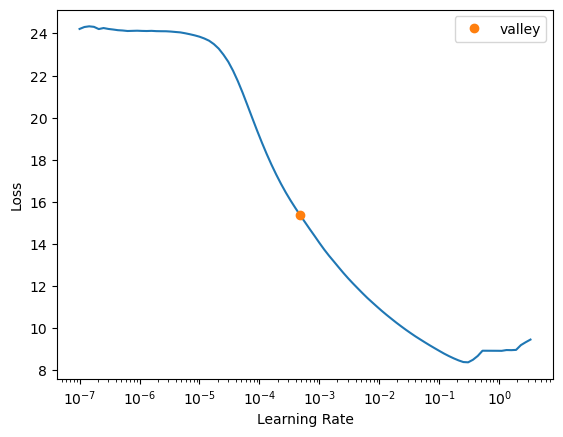

In [72]:
learn.lr_find()

In [86]:
learn.fit_one_cycle(40, 1e-3)

epoch,train_loss,valid_loss,acc,time


In [78]:
from plum import dispatch

@dispatch
def show_results(x:TensorImage, y:TensorText, samples, outs, ctxs=None, max_n=6, **kwargs):
    
    # ctxs = get_grid(min(len(samples), max_n)) if not ctxs else ctxs
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n))

    for i, ((img, tgt), pred) in enumerate(zip(samples, outs)):
        ctx = ctxs[i]
        img.show(ctx=ctx)
        
        # Decode target and prediction from TensorText
        tgt_str = CaptchaStr(tgt)
        pred_str = CaptchaStr(pred[0])
        
        ctx.set_title(f"Actual: {tgt_str}\nPred: {pred_str}", fontsize=8)
    
    return ctxs

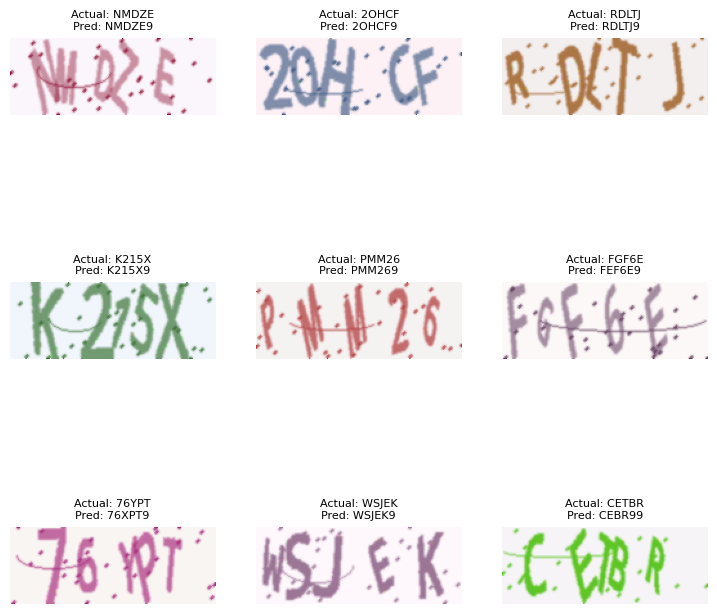

In [79]:
learn.show_results()

The model correctly identifies most CAPTCHAs, even with significant distortion and overlapping characters!

## The Machine Learning Mindset

What makes this approach successful isn't just the specific code, but the problem-solving pattern:

1. **Divide and conquer**: Separate image recognition from sequence interpretation
2. **Choose specialized tools**: CNNs for visual features, LSTMs for sequences
3. **Handle uncertainty**: Use CTC loss to manage the alignment problem
4. **Smart initialization**: Bias the model against blank predictions to avoid "blank collapse"
5. **Fine-tune learning rates**: Use different rates for different components

This same pattern can help solve many complex machine learning challenges:

- OCR for documents
- Speech recognition
- Video action recognition
- Medical time series analysis

## Going Further

Want to improve this model? Consider:

- Data augmentation (rotation, noise, blur) for more robust training
- Trying transformer architectures instead of LSTM
- Exploring beam search during decoding
- Testing on real-world CAPTCHAs (ethically, of course!)

Remember, the most valuable skill in machine learning isn't memorizing architectures—it's knowing how to decompose problems and connect specialized components in ways that leverage their strengths.

What machine learning challenge are you working on? Let me know in the comments!

- Processing medical imaging data with annotations

## Thinking Like a Machine Learning Engineer

The next time you face a complex ML problem, remember this approach:

1. What are the sub-problems?
2. What type of neural network is best for each part?
3. How do these parts need to talk to each other?
4. What's the right way to measure success?

By breaking down big problems into manageable pieces, even the most intimidating challenges become approachable.

So next time a CAPTCHA asks you to "prove you're human," you can smile knowing that the line between human and machine intelligence continues to blur—one squiggly character at a time.

*What machine learning challenge are you tackling? Share in the comments below!*